# Predicting Q3 grades using Portuguese school grades datasets

## Overview

Analyze student data and create a machine learning model to predict third term student performance. The primary goal is to predict G3 grades without using grades from the first two semesters (G1 and G2). 

The grading scale in the dataset is 0-20 with 20 being the highest score and 0 the lowest.

I use Sci-kit Learn to make Linear Regression, SVM Regression, Lasso Regression, Ridge Regression, Random Forest Regression, and stacking ensemble method.

Datasets were downloaded from the UC Irvine Machine Learning Repository: https://archive.ics.uci.edu/dataset/320/student+performance

## Getting the Data, Importing Packages

In [1]:
# importing packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error

from mpl_toolkits.mplot3d import Axes3D
from pandas.plotting import scatter_matrix

# Adding this to limit display and make it easier to see
pd.set_option('display.max_columns', 20)
import warnings
warnings.filterwarnings("ignore")

In [2]:
students = pd.read_csv("student-por.csv", sep=';') #read in CSV

In [3]:
# Initial data check
students.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-null    object
 20  higher    

In [ ]:
students.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [11]:
students.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
count,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000,395.000000
mean,16.696203,2.749367,2.521519,1.448101,2.035443,0.334177,3.944304,3.235443,3.108861,1.481013,2.291139,3.554430,5.708861,10.908861,10.713924,10.415190
std,1.276043,1.094735,1.088201,0.697505,0.839240,0.743651,0.896659,0.998862,1.113278,0.890741,1.287897,1.390303,8.003096,3.319195,3.761505,4.581443
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000,8.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000,20.000000


In [ ]:
# Correlations, have to convert columns to numeric to make the corr method work
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

students_numbered = students.replace({'yes': 1, 'no': 0, 'GP': 1, 'MS': 0, 'F': 1, 'M': 0, 'U': 1, 'R': 0, 'LE3': 0,
                                      'GT3': 1, 'T': 1, 'A': 0, "teacher": 4, "health": 3, "services": 2,
                                      "at_home": 1,"other": 0, "home": 3,"reputation": 2, "course": 1,
                                      "mother": 1, "father": 2})
students_numeric = students_numbered[["G3","Mjob","Fjob","reason","guardian","address","school","Pstatus","famsize","sex","romantic","schoolsup","famsup","paid","activities","nursery",
                                      "age","Medu","Fedu","famrel","traveltime","studytime","failures","higher",
                                      "internet","freetime","goout","Dalc","Walc","health","absences","G1","G2"]]
corr_matrix = students_numeric.corr()
corr_matrix
# variables over .1 correlation are: Walc, Dalc, freetime, internet, higher, failures, studytime, 'traveltime','Fedu','Medu', age, sex, school, address,
# reason, Mjob, 
#1 Create lists of features that will we use
# these are based on the high positive and negative correlations in the data exploration section


,G3,Mjob,Fjob,reason,guardian,address,school,Pstatus,famsize,sex,romantic,schoolsup,famsup,paid,activities,nursery,age,Medu,Fedu,famrel,traveltime,studytime,failures,higher,internet,freetime,goout,Dalc,Walc,health,absences,G1,G2
G3,1.000000,0.166790,0.065454,0.157546,0.079609,0.167637,0.284294,-0.000754,-0.045016,0.129077,-0.090583,-0.066405,0.059206,-0.054898,0.059791,0.028752,-0.106505,0.240151,0.211800,0.063361,-0.127173,0.249789,-0.393316,0.332172,0.150025,-0.122705,-0.087641,-0.204719,-0.176619,-0.098851,-0.091379,0.826387,0.918548
Mjob,0.166790,1.000000,0.313979,-0.014290,-0.010556,0.128512,0.151608,0.025812,-0.059604,-0.114223,-0.059196,-0.063127,0.092705,0.022049,0.118474,0.107690,-0.096202,0.536829,0.376360,0.002603,-0.143728,0.027832,-0.089040,0.134293,0.206238,0.045453,-0.012780,0.011831,0.059446,0.067353,-0.054078,0.169317,0.158552
Fjob,0.065454,0.313979,1.000000,-0.074679,0.164685,0.069587,0.018211,0.057947,0.045834,-0.054325,-0.003189,0.046903,0.063976,-0.027030,0.057043,0.011730,-0.094789,0.236021,0.363574,-0.013539,-0.102847,0.037830,-0.083033,0.064027,0.022623,-0.040034,-0.039938,0.039808,-0.006927,-0.008617,-0.041174,0.093530,0.085288
reason,0.157546,-0.014290,-0.074679,1.000000,-0.020612,0.163674,0.257056,-0.065814,-0.055543,-0.028519,-0.039456,0.054036,0.074655,0.005563,0.018903,-0.000899,-0.017911,0.100401,0.060966,-0.009077,-0.162217,0.095772,-0.118490,0.099880,0.120689,-0.041952,-0.015300,-0.026597,-0.015567,-0.072961,0.111391,0.151003,0.146615
guardian,0.079609,-0.010556,0.164685,-0.020612,1.000000,0.019359,-0.062333,0.169904,0.000872,-0.036811,-0.106190,0.041361,-0.016370,-0.071614,-0.014028,0.023060,-0.266830,0.014044,0.101764,0.052143,-0.026519,0.009911,-0.169605,0.114735,0.000412,-0.051442,-0.054880,-0.023330,0.008312,-0.016556,-0.150426,0.122676,0.097065
address,0.167637,0.128512,0.069587,0.163674,0.019359,1.000000,0.354520,-0.094635,-0.046113,-0.025503,-0.030939,0.017956,0.005577,-0.030483,-0.009278,0.018077,-0.025848,0.190320,0.141493,-0.033897,-0.344902,0.062023,-0.063824,0.076706,0.175794,-0.036647,0.015475,-0.047304,-0.012416,0.003787,0.073653,0.157127,0.154600
school,0.284294,0.151608,0.018211,0.257056,-0.062333,0.354520,1.000000,-0.028120,0.022252,-0.083050,-0.072241,0.123340,0.063720,0.007905,0.088604,-0.004659,-0.087170,0.254787,0.209806,0.031597,-0.252936,0.137857,-0.113788,0.136112,0.240486,-0.034666,-0.044632,-0.047169,-0.014169,0.058599,0.163933,0.292626,0.269776
Pstatus,-0.000754,0.025812,0.057947,-0.065814,0.169904,-0.094635,-0.028120,1.000000,0.239608,-0.064700,-0.053828,-0.009456,0.010203,0.015923,0.101555,-0.032724,-0.005631,-0.057174,-0.031856,0.051303,0.040633,-0.008748,-0.009881,0.022726,0.059754,0.037585,0.031086,0.041513,0.070976,0.012638,-0.117492,0.015251,0.018689
famsize,-0.045016,-0.059604,0.045834,-0.055543,0.000872,-0.046113,0.022252,0.239608,1.000000,0.098205,0.032936,0.056405,0.039819,0.050253,0.014790,-0.100686,0.002470,0.014325,0.039538,-0.004641,-0.012794,0.010945,0.066068,-0.004523,-0.013357,0.021257,0.004312,-0.060482,-0.081958,-0.002448,-0.004645,-0.047230,-0.038891
sex,0.129077,-0.114223,-0.054325,-0.028519,-0.036811,-0.025503,-0.083050,-0.064700,0.098205,1.000000,0.110144,0.111202,0.129467,-0.079300,-0.124707,0.043603,0.043662,-0.119127,-0.083913,-0.083473,-0.040880,0.206214,-0.073888,0.058134,-0.065911,-0.146305,-0.058178,-0.282696,-0.320785,-0.139547,-0.021336,0.104109,0.104005


In [99]:
G3_grade = students["G3"] #separate target values
students_1 = students.drop(columns=["G3"])

In [100]:
#splitting data into training and testing
X_train, X_test, y_train, y_test = train_test_split(students_1, G3_grade, test_size=0.2, random_state=42)

## Exploring the Training Data

In [6]:
# Attributes and Characteristics of Training Set
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 316 entries, 181 to 102
Data columns (total 32 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      316 non-null    object
 1   sex         316 non-null    object
 2   age         316 non-null    int64 
 3   address     316 non-null    object
 4   famsize     316 non-null    object
 5   Pstatus     316 non-null    object
 6   Medu        316 non-null    int64 
 7   Fedu        316 non-null    int64 
 8   Mjob        316 non-null    object
 9   Fjob        316 non-null    object
 10  reason      316 non-null    object
 11  guardian    316 non-null    object
 12  traveltime  316 non-null    int64 
 13  studytime   316 non-null    int64 
 14  failures    316 non-null    int64 
 15  schoolsup   316 non-null    object
 16  famsup      316 non-null    object
 17  paid        316 non-null    object
 18  activities  316 non-null    object
 19  nursery     316 non-null    object
 20  higher      3

In [7]:
X_train.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2
count,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000,316.000000
mean,16.743671,2.734177,2.544304,1.430380,2.047468,0.335443,3.943038,3.218354,3.161392,1.500000,2.344937,3.518987,5.905063,10.933544,10.651899
std,1.270217,1.080375,1.078476,0.688842,0.836258,0.735588,0.885464,1.020323,1.119480,0.903257,1.296395,1.410714,8.422033,3.216823,3.755930
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,5.000000,0.000000
25%,16.000000,2.000000,2.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,8.000000,9.000000
50%,17.000000,3.000000,3.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,4.000000,11.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,8.000000,13.000000,13.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,19.000000,19.000000


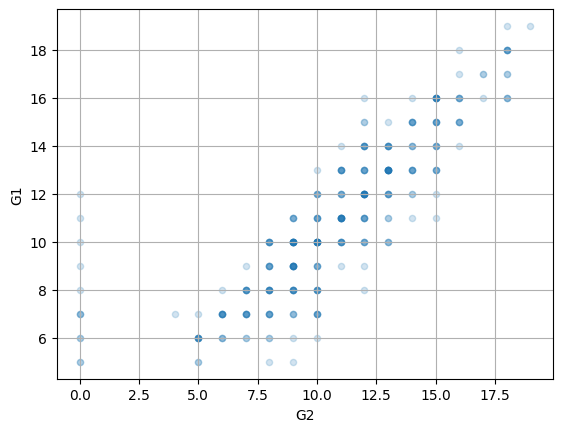

In [23]:
# More Visualizations (of training set)

# creates a scatterplot of training set
X_train.plot(kind="scatter", x="G2", y="G1", grid=True, alpha=0.2)
plt.show() # G1 and G2 line up well, student success in 1 is a good indicator of success in the other

<Axes: xlabel='G3', ylabel='G1'>

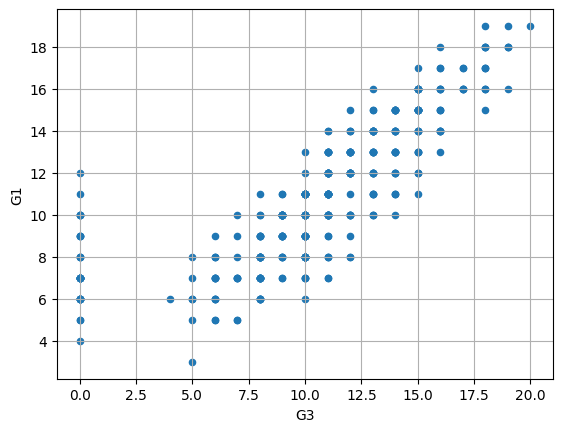

In [25]:
# Create the scatter plot
students.plot(kind="scatter", x="G3", y='G1', grid=True)  

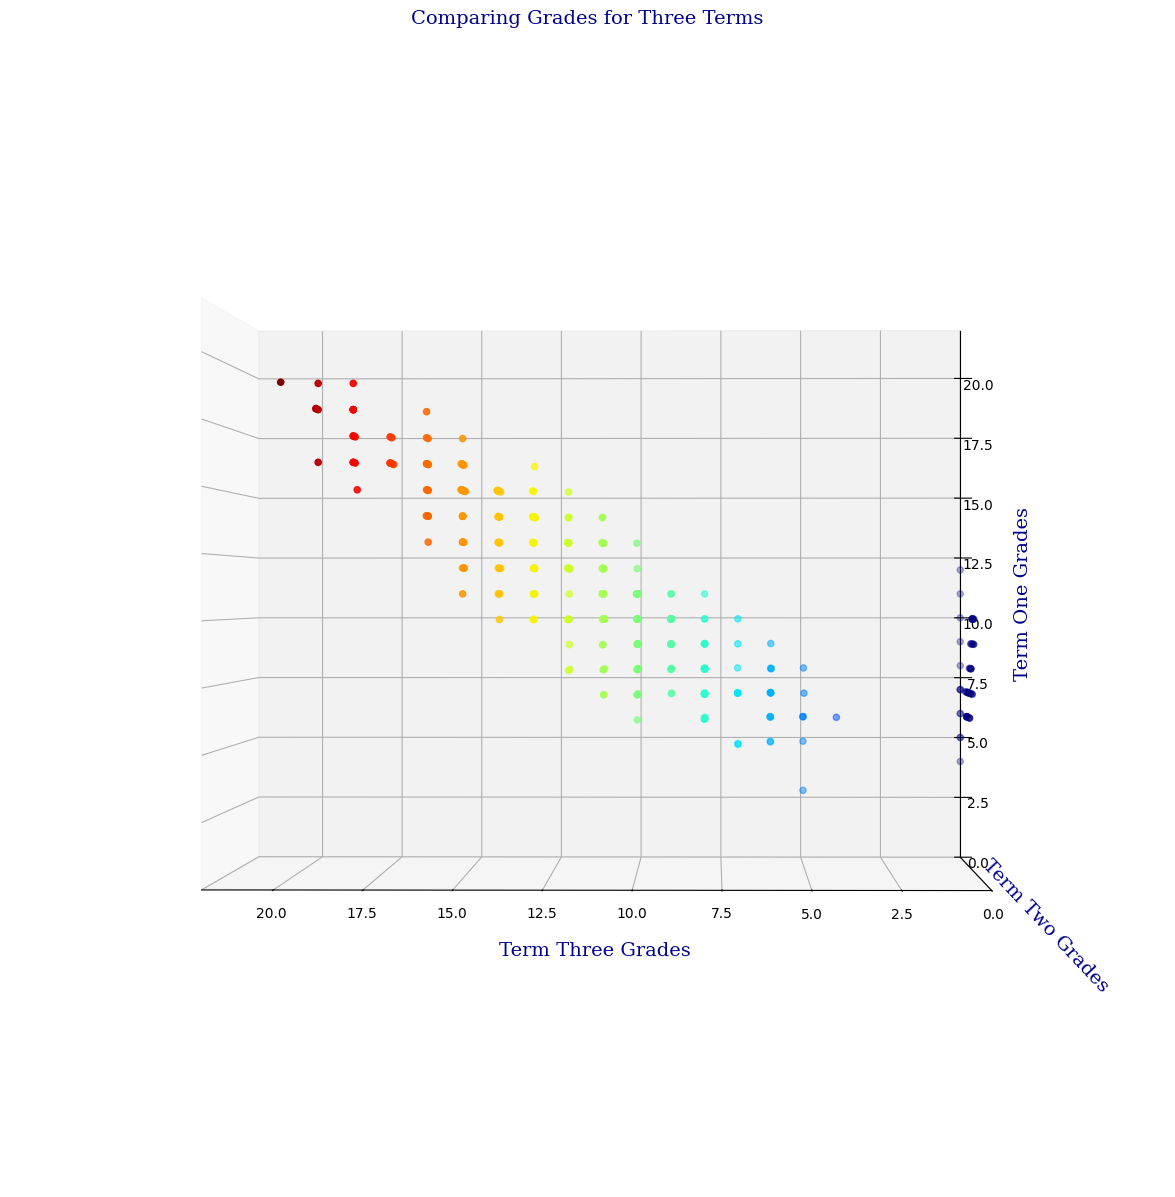

In [26]:
# Making plot with 4 subplots

# create the features
G1 = students['G1']
G2 = students['G2']
target = students['G3']
fig = plt.figure(figsize=[15, 15])
font = {'family': 'serif',
        'color':  'darkblue',
        'weight': 'normal',
        'size': 14,
        }
font2 = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 8,
        }
#  First subplot
plt.subplots_adjust(hspace= -10)
ax = fig.add_subplot(projection='3d')
ax.view_init(0, 91)
ax.set_title('Comparing Grades for Three Terms', fontdict=font)
ax.scatter3D(target, G2, G1, c=target, cmap='jet');
ax.set_xlabel('Term Three Grades',fontdict=font)
ax.set_ylabel('Term Two Grades',fontdict=font)
ax.set_yticks([])
ax.set_zlabel('Term One Grades',fontdict=font)
ax.set_xlim(0, 22)
ax.set_ylim(0, 22)
ax.set_zlim(0, 22)
ax.xaxis.labelpad = 20
ax.yaxis.labelpad = 20
ax.zaxis.labelpad = 20
# plt.show()
plt.savefig('terms1.jpg')

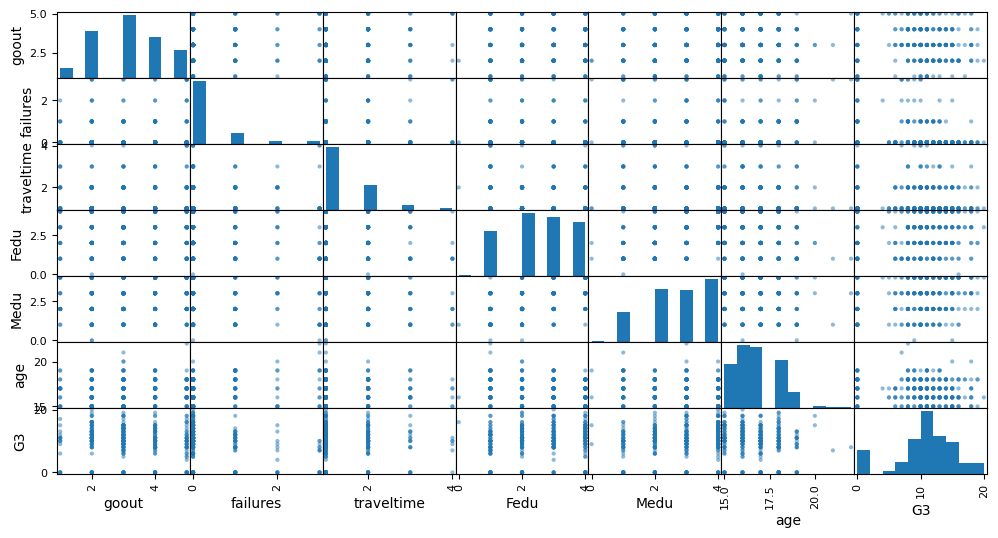

In [27]:
# plot matrix
# relevant numeric attributes from the training data
col_attributes = ['goout', 'failures', 'traveltime', 'Fedu', 'Medu', 'age']# combine training features and target into DataFrame
combined_df = pd.concat([X_train[col_attributes], y_train], axis=1)
# plots scatterplots and histograms
scatter_matrix(combined_df, figsize=(12, 6))
plt.show()

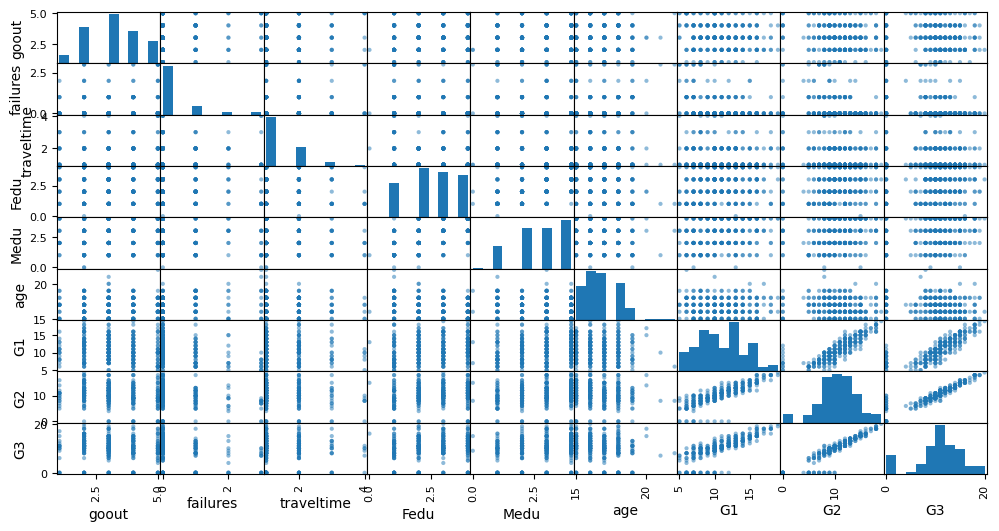

In [28]:
col_attributes = ['goout', 'failures', 'traveltime', 'Fedu', 'Medu', 'age','G1','G2']# combine training features and target into DataFrame
combined_df = pd.concat([X_train[col_attributes], y_train], axis=1)
# plots scatterplots and histograms
scatter_matrix(combined_df, figsize=(12, 6))
plt.show()

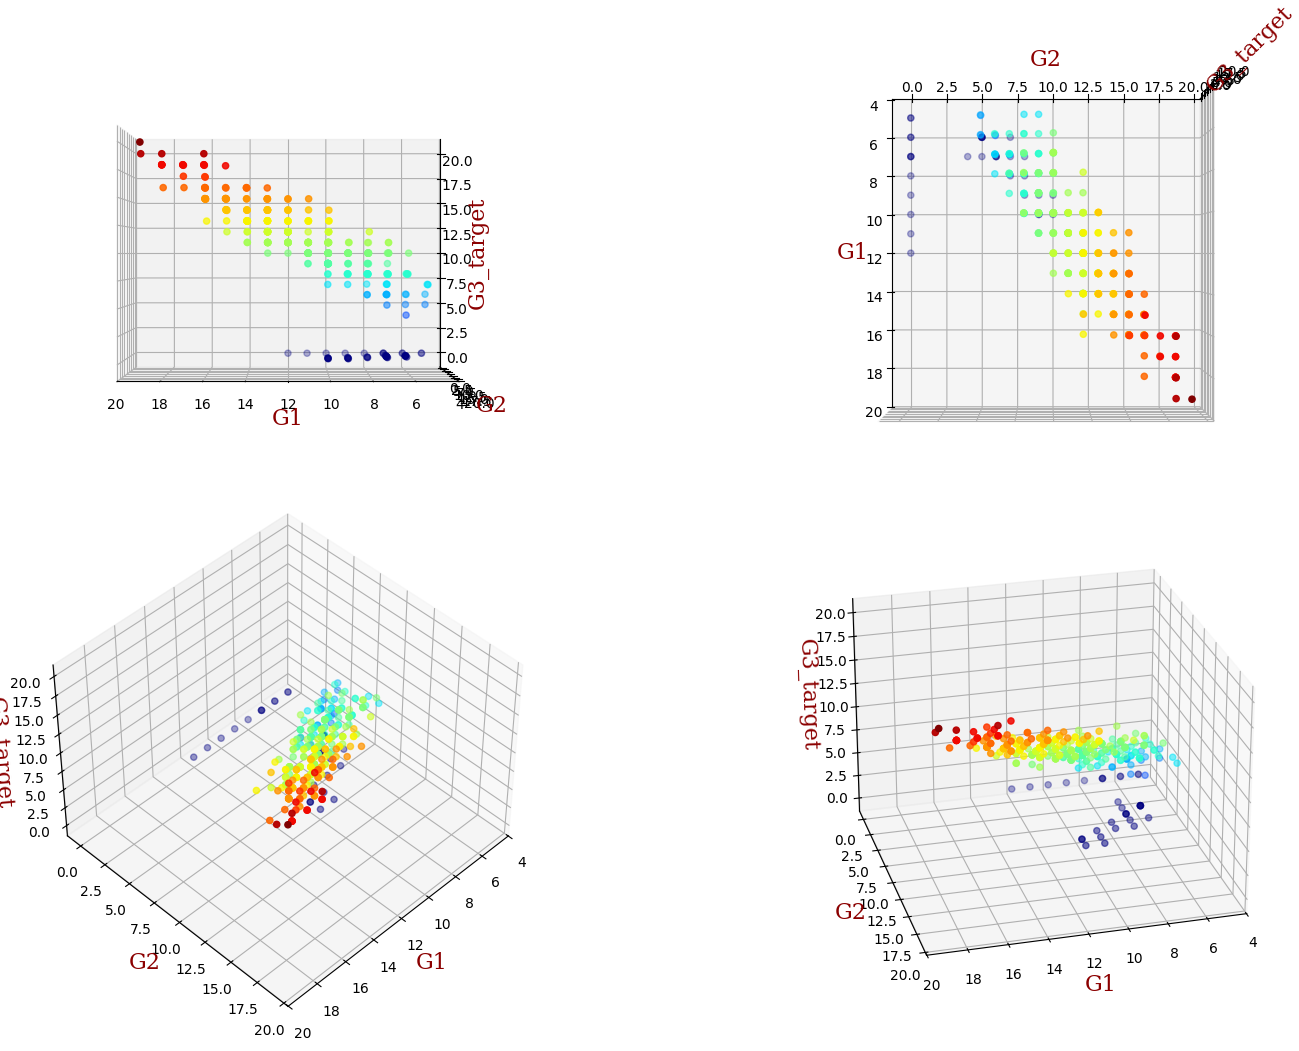

In [10]:
# Making plot with 4 subplots
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# create the features
G1 = X_train['G1']
G2 = X_train['G2']
target = y_train
fig = plt.figure(figsize=[18, 10])
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }
#  First subplot
ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.view_init(0, 90)
ax.scatter3D(G1, G2, target, c=target, cmap='jet');
ax.set_xlabel('G1',fontdict=font)
ax.set_ylabel('G2',fontdict=font)
ax.set_zlabel('G3_target',fontdict=font)

# Second subplot
ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.view_init(90, 0)
ax.scatter3D(G1, G2, target, c=target, cmap='jet');
ax.set_xlabel('G1',fontdict=font)
ax.set_ylabel('G2',fontdict=font)
ax.set_zlabel('G3_target',fontdict=font)

# Third subplot
ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.view_init(45, 45)

ax.scatter3D(G1, G2, target, c=target, cmap='jet');
ax.set_xlabel('G1',fontdict=font)
ax.set_ylabel('G2',fontdict=font)
ax.set_zlabel('G3_target',fontdict=font)

# Fourth subplot
ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.view_init(25, 75)
ax.scatter3D(G1, G2, target, c=target, cmap='jet');
ax.set_xlabel('G1',fontdict=font)
ax.set_ylabel('G2',fontdict=font)
ax.set_zlabel('G3_target',fontdict=font)
plt.tight_layout(pad=0.0, w_pad=0.0, h_pad=0.0)
plt.show()

In [9]:
# 3 Correlations
# selecting numeric attributes

col_attributes_2 = ['G1','G2','absences','failures','famrel','goout','Dalc','Walc','health','freetime','age','Medu','Fedu','traveltime','studytime']
# creating a new combined DataFrame
combined_df = pd.concat([X_train[col_attributes_2], y_train], axis=1)
# making correlations matrix
corr_matrix = combined_df.corr()
corr_matrix["G3"].sort_values(ascending=False)

G3            1.000000
G2            0.907924
G1            0.791559
Medu          0.215968
studytime     0.138200
Fedu          0.135265
famrel        0.069409
absences      0.064607
freetime     -0.015244
Walc         -0.057363
Dalc         -0.064698
health       -0.068857
goout        -0.106024
traveltime   -0.106752
age          -0.146241
failures     -0.373769
Name: G3, dtype: float64

## Data Preparation

### Feature Selection
Listing out columns for the transformers into:
- **numeric_columns**
- **categorical_columns**
- **ordinal_columns**

In [ ]:
#1 Create lists of features that will we use
# these are based on the high positive and negative correlations in the data exploration section
numeric_columns = ['failures','traveltime','Fedu','Medu','age','G1','G2']
ordinal_columns = ['Mjob']
categorical_columns = ['sex','address','higher']

Walc, Dalc, freetime, internet, studytime, school, reason,

### Custom Transformer

In [101]:
# Custom transformer to drop grades from G1 and G2


# Making the class
class NumericDataTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, drop_grades=True):
        self.drop_grades = drop_grades
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if self.drop_grades:
            X=X.drop(['G1','G2'], axis=1)
            return X
        else:
            return X


### Making Data Pipelines
These will apply the same transformations to new data and transform the data based upon the three column types (numeric, categorical, and ordinal). They will also separate the data into versions with and without the G1 and G2 columns.

In [134]:
numeric_pipeline_with_grades = make_pipeline (
    SimpleImputer(strategy="median").set_output(transform="pandas"),
    NumericDataTransformer(drop_grades=False),
    StandardScaler())

In [103]:
numeric_pipeline_without_grades = make_pipeline (
    SimpleImputer(strategy="median").set_output(transform="pandas"),
    NumericDataTransformer(),
    StandardScaler())

In [104]:
categorical_data_pipeline = make_pipeline (
    OneHotEncoder())

In [105]:
ordinal_data_pipeline = make_pipeline (
    OrdinalEncoder())

In [135]:

column_transformer_with_grades = ColumnTransformer ([
    ('num', numeric_pipeline_with_grades, numeric_columns),
    ('cat', categorical_data_pipeline, categorical_columns),
    ('ord', ordinal_data_pipeline, ordinal_columns)
])


In [107]:
column_transformer_without_grades = ColumnTransformer ([
    ('num', numeric_pipeline_without_grades, numeric_columns),
    ('cat', categorical_data_pipeline, categorical_columns),
    ('ord', ordinal_data_pipeline, ordinal_columns)
])


In [145]:
# using fit_transform to transform the X_train data with and without G1 and G2 data

X_train_transformed_with_grades = column_transformer_with_grades.fit_transform(X_train)

In [109]:
X_train_transformed_without_grades = column_transformer_without_grades.fit_transform(X_train)

In [136]:
X_train_transformed_with_grades[0]

array([-0.14439599, -0.45674383, -0.62577865,  0.42320737,  0.24643712,
       -0.58639605,  0.33205033,  0.62616324,  0.        ,  1.        ,
        0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
        1.        ,  0.        ,  1.        ,  3.        ])

In [137]:
X_train_transformed_without_grades[0]

array([-0.14439599, -0.45674383, -0.62577865,  0.42320737,  0.24643712,
       -0.58639605,  0.        ,  1.        ,  0.        ,  1.        ,
        0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
        1.        ,  3.        ])

## Regression Models
I run 4 regression models:
- Linear Regression
- Support Vector Machine (SVM) Regression
- Lasso Regression
- Ridge Regression
- Random Forest Regression
- Stacking Ensemble Method

I then examine each of them with cross-validation (10 folds) and look at the root mean squared (RMSE) value to see which ones are closer to the target values.

### Linear Regression

In [ ]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_transformed_with_grades, y_train)
lin_reg.fit(X_train_transformed_without_grades, y_train)


LinearRegression()

In [113]:
# Linear Regression Cross-Validation

cv_scores_lin_reg_with_grades = -cross_val_score(lin_reg, X_train_transformed_with_grades, y_train,
                                                 scoring="neg_root_mean_squared_error", cv=10)
cv_scores_lin_reg_without_grades = -cross_val_score(lin_reg, X_train_transformed_without_grades, y_train,
                                                    scoring="neg_root_mean_squared_error", cv=10)

In [44]:
# I am seeing all the folds to get a better interpretation
print(cv_scores_lin_reg_with_grades)
print(cv_scores_lin_reg_without_grades)

[2.27576843 1.99238001 1.17438908 1.80244305 1.80035618 1.85556344
 1.74808014 2.60312423 1.877195   1.81849448]
[4.77524591 4.71423399 3.16444413 4.38546778 4.45460839 4.65933201
 4.86762658 4.32756879 3.8004875  3.66659176]


In [ ]:
# Linear Regression Mean Cross-Validation Score
CV_lin_reg_with_grades = cv_scores_lin_reg_with_grades.mean()
print(CV_lin_reg_with_grades)
CV_lin_reg_without_grades = cv_scores_lin_reg_without_grades.mean()
print(CV_lin_reg_without_grades)

1.8947794025702946
4.28156068255823


### Lasso Regression

In [ ]:
# create model
lasso_reg = Lasso()
lasso_params = {
    'alpha' : [0.05, 0.1, 0.3, 1, 3, 5],
}


In [309]:
# Lasso GridSearch

lasso_grid = GridSearchCV(lasso_reg, lasso_params, cv=10, n_jobs=-1)

In [310]:
lasso_grid_with = lasso_grid.fit(X_train_transformed_with_grades, y_train)

In [312]:
lasso_grid_without = lasso_grid.fit(X_train_transformed_without_grades, y_train)

In [314]:
# Cross-Validation Scores

cv_scores_lasso_with_grades = -cross_val_score(lasso_grid_with, X_train_transformed_with_grades, y_train,
                                                scoring="neg_root_mean_squared_error", cv=10)
cv_scores_lasso_without_grades = -cross_val_score(lasso_grid_without, X_train_transformed_without_grades, y_train,
                                                  scoring="neg_root_mean_squared_error", cv=10)

In [248]:
# trying to make the interpretation easier by seeing all of the folds
# I think this is the best one. The mean is lower for both and the individual scores for each fold are typically better (save 3 in the lin_reg).
print(cv_scores_lasso_with_grades)
print(cv_scores_lasso_without_grades)

[2.29223068 1.89397529 1.13887151 1.81326919 1.59519068 1.86077134
 1.71706484 2.60758894 1.86070827 1.79497132]
[4.64285041 4.72759192 3.24416653 4.26072393 4.21771537 4.89648018
 4.90455646 4.43603232 3.91901272 3.82702836]


In [315]:
pd.Series(cv_scores_lasso_with_grades).describe()

count    10.000000
mean      1.857464
std       0.389272
min       1.138872
25%       1.736541
50%       1.836989
75%       1.885674
max       2.607589
dtype: float64

In [316]:
pd.Series(cv_scores_lasso_without_grades).describe()

count    10.000000
mean      4.307616
std       0.530360
min       3.244167
25%       3.993688
50%       4.348378
75%       4.706407
max       4.904556
dtype: float64

In [289]:
# Lasso Cross-Validation Score
CV_lasso_with_grades = cv_scores_lasso_with_grades.mean()
print(CV_lasso_with_grades)
CV_lasso_without_grades = cv_scores_lasso_without_grades.mean()
print(CV_lasso_without_grades)

1.8548054426883762
4.313684975326771


In [317]:
# check predictions

lasso_grid_with = lasso_grid.fit(X_train_transformed_with_grades, y_train)

X_test_transformed_with_grades = column_transformer_with_grades.transform(X_test)

lass_best_pred_with = lasso_grid_with.predict(X_test_transformed_with_grades)

lass_rmse_with_grades = root_mean_squared_error(y_test, lass_best_pred_with)

lass_r2_with_grades = r2_score(y_test, lass_best_pred_with)

In [318]:
lass_rmse_with_grades

2.149591926092366

In [319]:
lass_r2_with_grades

0.7746532652027724

In [320]:
lasswithout = lasso_reg.fit(X_train_transformed_without_grades, y_train)

X_test_transformed_without_grades = column_transformer_without_grades.transform(X_test)

best_pred_without = lasswithout.predict(X_test_transformed_without_grades)

lass_rmse_without_grades = root_mean_squared_error(y_test, best_pred_without)

lass_r2_without_grades = r2_score(y_test, best_pred_without)

In [321]:
lass_rmse_without_grades

4.3759724418479164

In [322]:
lass_r2_without_grades

0.06612579032506105

### SVM Regression

In [ ]:
# create model

svm_reg = SVR()

svm_reg.fit(X_train_transformed_with_grades, y_train)
svm_reg.fit(X_train_transformed_without_grades, y_train)


SVR()

In [51]:
# SVM Cross-Validation

cv_scores_svm_with_grades = -cross_val_score(svm_reg, X_train_transformed_with_grades, y_train,
                                             scoring="neg_root_mean_squared_error", cv=10)
cv_scores_svm_without_grades = -cross_val_score(svm_reg, X_train_transformed_without_grades, y_train,
                                                scoring="neg_root_mean_squared_error", cv=10)

In [52]:
# trying to make the interpretation easier by seeing all of the folds
print(cv_scores_svm_with_grades)
print(cv_scores_svm_without_grades)

[3.18290615 2.67514747 1.50033014 2.40887796 1.95961236 2.73473356
 2.24883769 3.05681685 2.48068997 2.55238372]
[4.86714037 4.64286848 3.3421397  4.34145755 3.48852171 4.82158251
 4.93364672 4.3885867  3.71479383 3.96832156]


In [ ]:
# SVM Mean Cross-Validation Score
CV_svm_with_grades = cv_scores_svm_with_grades.mean()
print(CV_svm_with_grades)
CV_svm_without_grades = cv_scores_svm_without_grades.mean()
print(CV_svm_without_grades)

2.4800335868771306
4.250905913726104


### Ridge Regression

In [390]:
# Ridge Regression

ridge_reg = Ridge()
ridge_params = {
    'alpha' : [0.05, 0.1, 0.3, 1, 3, 5, 6, 8, 10, 15, 30, 50, 75],
}


In [391]:
# Grid search

ridge_grid = GridSearchCV(ridge_reg, ridge_params, cv=10, n_jobs=-1)

In [393]:
ridge_grid_with = ridge_grid.fit(X_train_transformed_with_grades, y_train)

X_test_transformed_with_grades = column_transformer_with_grades.transform(X_test)

best_pred_with = ridge_grid_with.predict(X_test_transformed_with_grades)

ridge_rmse_with_grades = root_mean_squared_error(y_test, best_pred_with)

ridge_r2_with_grades = r2_score(y_test, best_pred_with)

In [394]:
ridge_rmse_with_grades

2.195160216034142

In [395]:
ridge_r2_with_grades

0.7649979387482997

In [396]:
ridge_grid_without = ridge_grid.fit(X_train_transformed_without_grades, y_train)

X_test_transformed_without_grades = column_transformer_without_grades.transform(X_test)

best_pred_without = ridge_grid_without.predict(X_test_transformed_without_grades)

ridge_rmse_without_grades = root_mean_squared_error(y_test, best_pred_without)

ridge_r2_without_grades = r2_score(y_test, best_pred_without)

In [397]:
ridge_rmse_without_grades

4.1492865157631265

In [398]:
ridge_r2_without_grades

0.16037362095203167

In [357]:
# Ridge Regression Cross-Validation

cv_scores_ridge_reg_with_grades = -cross_val_score(ridge_grid_with, X_train_transformed_with_grades, y_train,
                                                   scoring="neg_root_mean_squared_error", cv=10)
cv_scores_ridge_reg_without_grades = -cross_val_score(ridge_grid_without, X_train_transformed_without_grades, y_train,
                                                      scoring="neg_root_mean_squared_error", cv=10)

In [56]:
# trying to make the interpretation easier by seeing all of the folds
print(cv_scores_ridge_reg_with_grades)
print(cv_scores_ridge_reg_without_grades)

[2.27692937 1.99038908 1.16993403 1.79874973 1.80195356 1.85300648
 1.74663134 2.60609019 1.87392125 1.81869956]
[4.77060374 4.71461605 3.16496779 4.37850872 4.42897991 4.6597158
 4.86944929 4.32716533 3.80039719 3.66992236]


In [358]:
# Ridge Regression Mean Cross-Validation Score
CV_ridge_reg_with_grades = cv_scores_ridge_reg_with_grades.mean()
print(CV_ridge_reg_with_grades)

CV_ridge_reg_without_grades = cv_scores_ridge_reg_without_grades.mean()
print(CV_ridge_reg_without_grades)

1.8917155949771431
4.2463783871136815


### Random Forest Regression

In [366]:
# Create model

forest_reg = RandomForestRegressor(random_state=42)
forest_params = {
    'n_estimators' : [100, 200, 300]
}


In [367]:
# Grid Search
forest_grid = GridSearchCV(forest_reg, forest_params, cv=10, n_jobs=-1)

In [368]:
forest_grid_with = forest_grid.fit(X_train_transformed_with_grades, y_train)
forest_grid_without = forest_grid.fit(X_train_transformed_without_grades, y_train)

In [369]:
forest_grid_with

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'n_estimators': [100, 200, 300]})

In [ ]:
forest_grid_with = forest_grid.fit(X_train_transformed_with_grades, y_train)

X_test_transformed_with_grades = column_transformer_with_grades.transform(X_test)

best_pred_with = forest_grid_with.predict(X_test_transformed_with_grades)

forest_rmse_with_grades = root_mean_squared_error(y_test, best_pred_with)

forest_r2_with_grades = r2_score(y_test, best_pred_with)



In [372]:
forest_rmse_with_grades

2.3154177795099713

In [373]:
forest_r2_with_grades

0.7385443972118901

In [374]:
forest_grid_without = forest_grid.fit(X_train_transformed_without_grades, y_train)

X_test_transformed_without_grades = column_transformer_without_grades.transform(X_test)

best_pred_without = forest_grid_without.predict(X_test_transformed_without_grades)

forest_rmse_without_grades = root_mean_squared_error(y_test, best_pred_without)

forest_r2_without_grades = r2_score(y_test, best_pred_without)

In [375]:
forest_rmse_without_grades

4.435296727404671

In [376]:
forest_r2_without_grades

0.040633420496280714

In [379]:
# Forest Regression Cross-Validation

cv_scores_forest_reg_with_grades = -cross_val_score(forest_grid_with, X_train_transformed_with_grades, y_train,
                                                   scoring="neg_root_mean_squared_error", cv=10)
cv_scores_forest_reg_without_grades = -cross_val_score(forest_grid_without, X_train_transformed_without_grades, y_train,
                                                      scoring="neg_root_mean_squared_error", cv=10)

In [380]:
# Forest Regression Mean Cross-Validation Score
CV_forest_reg_with_grades = cv_scores_forest_reg_with_grades.mean()
print(CV_forest_reg_with_grades)

CV_forest_reg_without_grades = cv_scores_forest_reg_without_grades.mean()
print(CV_forest_reg_without_grades)

1.9151746696444334
4.528148186628881


### Stacked Ensemble Method

In [381]:
# Stacked Ensemble Method to try to improve the scores

stacking_model = StackingRegressor(
    estimators=[
        ('ridge', ridge_grid.best_estimator_),
        ('lasso', lasso_grid.best_estimator_),
        ('svm', svm_reg),
        ('linear', lin_reg),
        ('for', forest_grid.best_estimator_)
    ],
    cv=10
)

model_with = stacking_model.fit(X_train_transformed_with_grades, y_train)
model_without = stacking_model.fit(X_train_transformed_without_grades, y_train)


In [382]:
# stacking Cross-Validation

cv_scores_stacking_model_with_grades = -cross_val_score(model_with, X_train_transformed_with_grades, y_train,
                                                        scoring="neg_root_mean_squared_error", cv=10)
cv_scores_stacking_model_without_grades = -cross_val_score(model_without, X_train_transformed_without_grades, y_train,
                                                           scoring="neg_root_mean_squared_error", cv=10)

In [383]:
CV_stacking_model_with_grades = cv_scores_stacking_model_with_grades.mean()
print(CV_stacking_model_with_grades)

CV_stacking_model_without_grades = cv_scores_stacking_model_without_grades.mean()
print(CV_stacking_model_without_grades)

1.857340614040299
4.258908240473527


In [384]:
# RMSE score for stacked method
model_with = stacking_model.fit(X_train_transformed_with_grades, y_train)

X_test_transformed_with_grades = column_transformer_with_grades.transform(X_test)

best_pred = model_with.predict(X_test_transformed_with_grades)

rmse_with_grades = root_mean_squared_error(y_test, best_pred)

r2_with_grades = r2_score(y_test, best_pred)

In [385]:
rmse_with_grades

2.1619006530944285

In [386]:
r2_with_grades

0.7720651714307929

In [387]:
model_without = stacking_model.fit(X_train_transformed_without_grades, y_train)

X_test_transformed_without_grades = column_transformer_without_grades.transform(X_test)

best_pred_without = model_without.predict(X_test_transformed_without_grades)

rmse_without_grades = root_mean_squared_error(y_test, best_pred_without)

r2_without_grades = r2_score(y_test, best_pred_without)

In [388]:
rmse_without_grades

4.140220697005828

In [389]:
r2_without_grades

0.16403862932757007

## Performance Measurements with Test Set
The Ridge Regression, Lasso Regression, Random Forest, and Stacked models were measured with the test set in the previous section. In this section, I will visualize the results of these models to show which ones are the best.

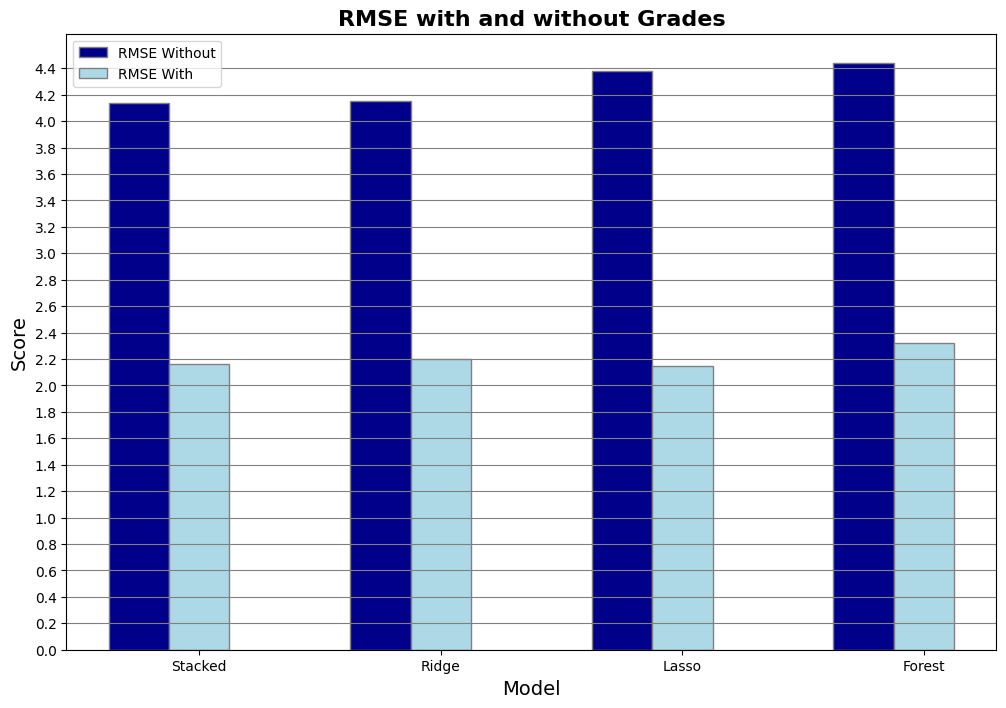

In [404]:

# stacking without: r2 = 0.16403862932757007, RMSE = 4.140220697005828

# Random Forest without: R2 = 0.040633420496280714, RMSE = 4.435296727404671

# Lasso without: R2 = 0.06612579032506105, RMSE = 4.3759724418479164

# Ridge without: R2 = 0.16037362095203167, RMSE = 4.1492865157631265


# stacking with: R2 = 0.7720651714307929, RMSE = 2.1619006530944285

# random forest with: R2 = 0.7385443972118901, RMSE = 2.3154177795099713

# lasso with: R2 = 0.7746532652027724, RMSE = 2.149591926092366

# ridge with: R2 = 0.7649979387482997, RMSE = 2.195160216034142


barWidth = 0.25
fig = plt.subplots(figsize =(12, 8)) 
plt.title('RMSE with and without Grades', fontweight ='bold', fontsize=16)
RMSE_without = [4.14, 4.15, 4.38, 4.44] 
RMSE_with = [2.16, 2.2, 2.15, 2.32] 

br1 = np.arange(len(RMSE_without)) 
br2 = [x + barWidth for x in br1] 

plt.bar(br1, RMSE_without, color ='darkblue', width = barWidth, 
        edgecolor ='grey', label ='RMSE Without') 
plt.bar(br2, RMSE_with, color ='lightblue', width = barWidth, 
        edgecolor ='grey', label ='RMSE With') 

plt.xlabel('Model', fontsize = 14) 
plt.ylabel('Score', fontsize = 14) 
plt.yticks(np.arange(0, 4.5, 0.20))
plt.grid(axis='y', color = 'gray')
plt.xticks([r + barWidth for r in range(len(RMSE_without))], 
        ['Stacked', 'Ridge', 'Lasso', 'Forest'])

plt.legend()
plt.show() 


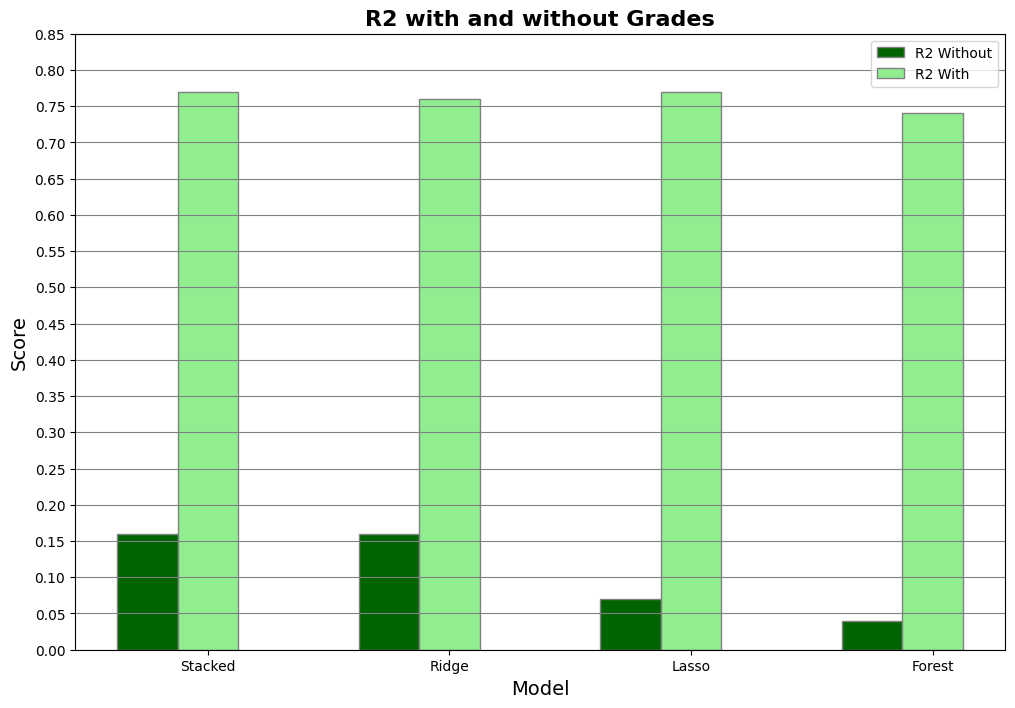

In [410]:
# stacking without: r2 = 0.16403862932757007, RMSE = 4.140220697005828

# Random Forest without: R2 = 0.040633420496280714, RMSE = 4.435296727404671

# Lasso without: R2 = 0.06612579032506105, RMSE = 4.3759724418479164

# Ridge without: R2 = 0.16037362095203167, RMSE = 4.1492865157631265


# stacking with: R2 = 0.7720651714307929, RMSE = 2.1619006530944285

# random forest with: R2 = 0.7385443972118901, RMSE = 2.3154177795099713

# lasso with: R2 = 0.7746532652027724, RMSE = 2.149591926092366

# ridge with: R2 = 0.7649979387482997, RMSE = 2.195160216034142


barWidth = 0.25
fig = plt.subplots(figsize =(12, 8)) 
plt.title('R2 with and without Grades', fontweight ='bold', fontsize=16)
R2_without = [0.16, 0.16, 0.07, 0.04] 
R2_with = [0.77, 0.76, 0.77, 0.74] 

br1 = np.arange(len(R2_without)) 
br2 = [x + barWidth for x in br1] 

plt.bar(br1, R2_without, color ='darkgreen', width = barWidth, 
        edgecolor ='grey', label ='R2 Without') 
plt.bar(br2, R2_with, color ='lightgreen', width = barWidth, 
        edgecolor ='grey', label ='R2 With') 

plt.xlabel('Model', fontsize = 14) 
plt.ylabel('Score', fontsize = 14) 
plt.yticks(np.arange(0, 0.9, 0.05))
plt.grid(axis='y', color = 'gray')
plt.xticks([r + barWidth for r in range(len(R2_without))], 
        ['Stacked', 'Ridge', 'Lasso', 'Forest'])

plt.legend()
plt.show() 

**Discussion**
The models with grades are decent. They can predict the grades within a couple points. The point scales are 0-20 so 2 points is a more significant difference than a 0-100 grading scale, but they still have decently strong prediction ability.

The models without grades are not nearly as helpful. The stacked model is the best, but even this 


None of the models are great, especially without the grades from G1 and G2. However, the Lasso model is the best option, though as shown in the final 
code block it is only marginally better than the svm best model option.
In addition, the R2 for the Lasso and SVM with grades is fairly good even though the root mean square error is high.